<a href="https://colab.research.google.com/github/youssefsalah224/fine-tuning_Spam-torch/blob/main/fine_tuning_torch_Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Fine-Tuning Bert Model on SMS Spam Dataset Using Torch</h3>

In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader

from datasets import Dataset
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW



from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("spam.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'spam.csv'

In [ ]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [ ]:
df.shape

(5572, 2)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(5157, 2)

In [ ]:
df['label'].value_counts()

label
0    4516
1     641
Name: count, dtype: int64

In [ ]:
ham_set = df[df['label'] == 0]
ham_set.shape

(4516, 2)

In [ ]:
spam_set = df[df['label'] == 1]
spam_set.shape

(641, 2)

In [ ]:
ham_set = ham_set.sample(641)
ham_set.shape

(641, 2)

In [ ]:
df_merged = pd.concat([ham_set, spam_set], ignore_index=True, sort=False)

In [ ]:
df_merged = df_merged.sample(frac=1)

In [ ]:
df_merged.shape

(1282, 2)

In [ ]:
train_df, test_df = train_test_split(df_merged, test_size=0.25)

In [ ]:
print(train_df.shape, test_df.shape)

(961, 2) (321, 2)


In [ ]:
# Pandas to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def tokenize_data(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

In [ ]:
train_dataset = train_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/961 [00:00<?, ? examples/s]

Map:   0%|          | 0/321 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Last Layers to Fine-tune
layers_to_train = 2

# Freeze Other Layers
for param in model.parameters():
    param.requires_grad = False

for param in model.bert.encoder.layer[-layers_to_train:].parameters():
    param.requires_grad = True

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Training loop
for epoch in range(4):
    model.train()
    for batch in train_loader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Calculate loss
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
# Evaluation
model.eval()
total_accuracy = 0.0
total_samples = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(outputs.logits.softmax(dim=1).cpu().numpy()[:, 1])
        total_accuracy += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

In [ ]:
accuracy = total_accuracy / total_samples
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9750778816199377


In [ ]:
precision = precision_score(all_labels, all_preds, pos_label=1)
print(f"Precision: {precision}")

Precision: 0.9748427672955975


In [ ]:
recall = recall_score(all_labels, all_preds, pos_label=1)
print(f"Recall: {recall}")

Recall: 0.9748427672955975


In [ ]:
f1 = f1_score(all_labels, all_preds, pos_label=1)
print(f"F1 Score: {f1}")

F1 Score: 0.9748427672955975


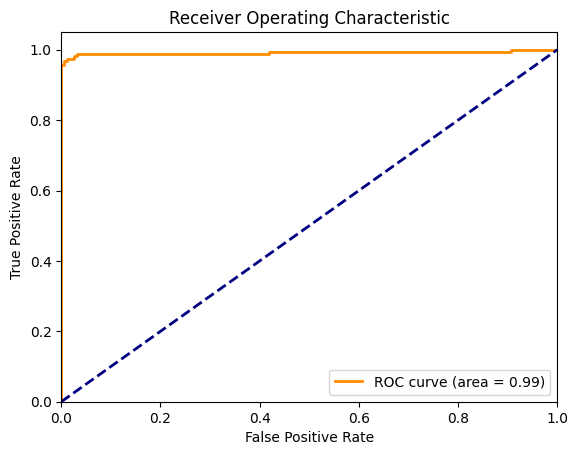

In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Classification report
report = classification_report(all_labels, all_preds, target_names=['ham', 'spam'])
print(report)

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       162
        spam       0.97      0.97      0.97       159

    accuracy                           0.98       321
   macro avg       0.98      0.98      0.98       321
weighted avg       0.98      0.98      0.98       321



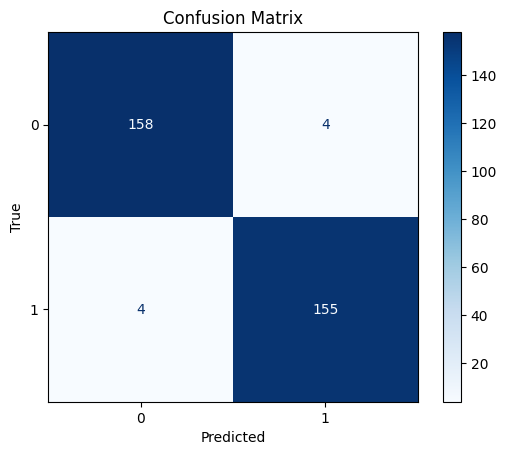

In [ ]:
# Confusion matrix
confusion_matrix = confusion_matrix(all_labels, all_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot(cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()